Reconstruct CI image from the parameters of CI

In [15]:
%%time
import numpy as np
import seaborn as sns

from PIL import Image
paras_ci = np.load(r'D:\cnnface\female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')
patches = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patches.npy')
patchIdx = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patchidx.npy').astype('int64')
# Reconstruct CI image from the parameters of CI
noise= generateCI(patches,patchIdx,paras_ci)
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise)*75

Wall time: 1.72 s


In [18]:
noise = nor(noise)*255
noise_img = Image.fromarray(noise).convert('RGB')
noise_img.save(r'D:\cnnface\Emotion_analysis\CI_analysis\ci/ci_paras.jpg')

In [ ]:
base_face = np.array(Image.open(r'D:\cnnface\Emotion_analysis\face_template/neutral_average_gray.jpg').convert('L')).astype('int64')


bf_add = base_face + noise 
bf_sub = base_face - noise

bf_add = nor(bf_add)*255
bf_sub = nor(bf_sub)*255

(Image.fromarray(bf_add.astype('uint8'))).save('D:\cnnface\Emotion_analysis\CI_analysis\ci/neu_bf_add.jpg',quality=95)
(Image.fromarray(bf_sub.astype('uint8'))).save('D:\cnnface\Emotion_analysis\CI_analysis\ci/neu_bf_sub.jpg',quality=95)

In [236]:
# calculate the index of different frequency noise
scales = [2**i for i in range(1,5+1)]
NumPatch = [(scale / 2) ** 2 for scale in scales]
NumParam = [ int(num*12) for num in NumPatch]
print(NumParam)
l = [sum(NumParam[:i+1]) for i in range(len(NumParam))]
print(l)
idx = [i*12 for i in range(6)]
print(idx)

Slice the different level of frequency from CI

In [57]:
# slice the different level of frequency from ci
noise_2 = np.sum(patches[:,:,:12] * patchIdx[:,:,:12],axis=2)
noise_4 = np.sum(patches[:,:,12:24] * patchIdx[:,:,12:24],axis=2)
noise_8 = np.sum(patches[:,:,24:36] * patchIdx[:,:,24:36],axis=2)
noise_16 = np.sum(patches[:,:,36:48] * patchIdx[:,:,36:48],axis=2)
noise_32 = np.sum(patches[:,:,48:60] * patchIdx[:,:,48:60],axis=2)

noise_list = [noise_2,noise_4, noise_8, noise_16,noise_32]
nor = lambda x:(x-x.min())/(x.max() - x.min())
for i,noi in enumerate(noise_list):
     noise_list[i] = nor(noi) * 40

In [58]:
# baseface add noise or subtract noise and save the different frequency CI
from PIL import Image

frame54 = Image.open('D:\cnnface/female_male_test_51_addnoise\Face_template/face_template/frame054_gray_512.jpg')
baseFace = np.array(frame54).astype('float64')
scale = [2,4,8,16,32]
print('baseface max:{} min:{}'.format(baseFace.max(),baseFace.min()))

for s,nx in zip(scale,noise_list):
    
    bf_add = baseFace + nx
    bf_sub = baseFace - nx
    print(bf_add.max())
    print(bf_sub.min())

    bf_add = nor(bf_add) *255
    bf_sub = nor(bf_sub) *255
    
    bf_add_img = Image.fromarray(bf_add).convert('RGB')
    bf_sub_img = Image.fromarray(bf_sub).convert('RGB')
    bf_add_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/40_CI_add_{}.jpg'.format(s))
    bf_sub_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/40_CI_sub_{}.jpg'.format(s))


#### Multi variable linear regression model for each of the 4092 components

In [33]:
import numpy as np
import statsmodels.api as sm

x = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')

label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')

y = np.arange(5000)
y[label_f] = int(0)
y[label_m] = int(1)

rm = sm.OLS(endog=y,exog=x[:,12:60]).fit()
print(rm.summary())
print('pvalues <0.05:',np.argwhere(np.array(rm.pvalues)<0.05))

Independent t test for 4092 parameters

In [4]:
import numpy as np
from scipy import stats
 
params_5000 = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')

label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')


s_sum = []
p_sum= [] 
for i in range(4092):
    x_5000 = params_5000[:,i]
    x_f = x_5000[label_f]
    x_m = x_5000[label_m]
    
    s,p = stats.ttest_ind(x_f,x_m)
    s,p = stats.f_oneway(x_f,x_m)
    s_sum.append(s)
    p_sum.append(p)

In [13]:
p_sum = np.array(p_sum)
s_sum = np.array(s_sum)
p_sum_sign = p_sum[p_sum<(0.01/4092)]
p_signIndex = np.squeeze(np.argwhere(p_sum<(0.01/4092)))
p_minIndex = np.argwhere(p_sum==p_sum.min())


np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_signIndex_0.01',p_signIndex)
# np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_sum',p_sum)
# np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/s_sum',s_sum)

In [35]:
np.argwhere(p_sum==p_sum[p_signIndex].max())

array([[2216]], dtype=int64)

In [269]:
import matplotlib.pyplot as plt
x_5000 = params_5000[:,595]
x_f = x_5000[label_f]
x_m = x_5000[label_m]

bins = np.arange(-1,1,2/10) 
plt.hist(x_f,bins,normed=True,alpha = 0.9)
plt.hist(x_m,bins,normed=True,alpha = 0.4)
plt.savefig('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/x_56_scatter.png')


In [270]:
ss = s_sum[p_signIndex]
ss_pos = ss[ss>0]
ss_neg = ss[ss<0]

bin = np.arange(ss_neg.min(),ss_pos.max(),2/5)
sns.distplot(ss_pos,bin)
sns.distplot(ss_neg,bin)
#plt.savefig('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/s_sign_hist.jpg')


In [254]:
scale2_pSign = p_signIndex[p_signIndex<12 ]
scale4_pSign = p_signIndex[(p_signIndex>=12) & (p_signIndex<60)]
scale8_pSign = p_signIndex[(p_signIndex>=60) & (p_signIndex<252)]
scale16_pSign = p_signIndex[(p_signIndex>=252) & (p_signIndex<1020)]
scale32_pSign = p_signIndex[(p_signIndex>=1020) & (p_signIndex<4092)]

pSign_num = [len(scale2_pSign),len(scale4_pSign),len(scale8_pSign),len(scale16_pSign),
             len(scale32_pSign)]
print(pSign_num)
plt.hist()
pSign_prop = [len(scale2_pSign)/12,len(scale4_pSign)/48,len(scale8_pSign)/192,
              len(scale16_pSign)/768,len(scale32_pSign)/3072]
print(pSign_prop)

In [294]:
p_posIndex = np.intersect1d(p_signIndex,np.argwhere(s_sum>0))
p_negIndex = np.intersect1d(p_signIndex,np.argwhere(s_sum<0))
np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_posIndex',p_posIndex)
np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_negIndex',p_negIndex)

In [296]:
para_sign = np.zeros(4092)
para_sign[p_posIndex.astype('int64')] = 1
para_sign[p_posIndex.astype('int64')] = -1

#noise generate 
patches = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patches.npy')
patchIdx = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patchidx.npy')
for i in range(4092):
    if i%100 == 0:print(i)
    patchIdx[patchIdx==i+1] = para_sign[i]
noise = np.sum(patches * patchIdx,axis=2)
print(noise.shape)
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise) *80
from PIL import Image
noise_img = Image.fromarray(noise)
noise_img.show()

# base face add CI

# 

In [305]:
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise) *43

frame54 = Image.open('D:\cnnface/female_male_test_51_addnoise\Face_template/face_template/frame054_gray_512.jpg')
baseFace = np.array(frame54).astype('float64')

bf_add = baseFace + noise
bf_sub = baseFace - noise
print(bf_add.max())
print(bf_sub.min())

bf_add = nor(bf_add) *255
bf_sub = nor(bf_sub) *255

bf_add_img = Image.fromarray(bf_add).convert('RGB')
bf_sub_img = Image.fromarray(bf_sub).convert('RGB')
bf_add_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/Sign_CI_add.jpg')
bf_sub_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/Sign_CI_sub.jpg')

Plot Manhattan map of distance which measure the distance of two distributions

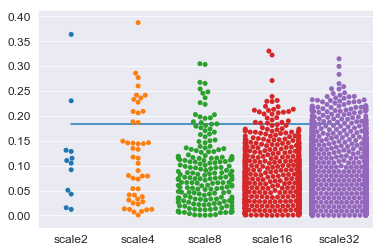

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# load data 
params_5000 = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')
label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')

# Calculate the distance of two distributions
# distance can be t-Statistic , KL divergence, Js divergence, Wasserstein distance
dis_sum = [] 
for i in range(4092):
    x_5000 = params_5000[:,i]
    x_f = x_5000[label_f]
    x_m = x_5000[label_m]
    
    # dis = stats.ttest_ind(x_f,x_m)    
    
    d = lambda x1,x2: (x1.mean() - x2.mean()) / np.sqrt(((np.std(x1))**2 + (np.std(x2))**2)/2)
    dis = np.abs(d(x_f,x_m))

    dis_sum.append(dis)
    

dis_sum = np.array(dis_sum)

scale2 = ['scale2'] * 12
scale4 = ['scale4'] * 48
scale8 = ['scale8'] * 192
scale16 = ['scale16'] * 768
scale32 = ['scale32'] * 3072
scale = scale2 + scale4 + scale8 + scale16 + scale32


# plot the manhattan map
snsplt =sns.swarmplot(x=scale,y=dis_sum)
plt.tick_params(labelsize=12)
# plot the significant line
bin = np.arange(0,5)
y = np.full((5,),dis_sum[2216])
snsplt = sns.lineplot(x=bin,y=y)

fig =snsplt.get_figure()
fig.savefig('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/Manhatannx_cohensd.jpg')
plt.show()
